# Chapter 4: Training Models

## Linear Regression

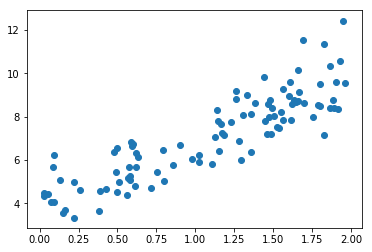

In [112]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = 2 * np.random.rand(100, 1)
y = 4 + 3 * x + np.random.randn(100,1)

plt.scatter(x,y)
plt.show()

In [9]:
# Find the paramaters for a linear fit

x_b = np.c_[np.ones((100,1)), x]
theta_best = np.linalg.inv(x_b.T @ x_b ) @ x_b.T @ y
theta_best

array([[4.29952091],
       [2.80287147]])

In [15]:
# make predictions using this model

x_new = np.array([[0], [2]])
x_new_b = np.c_[np.ones((2,1)), x_new]
y_pred = x_new_b @ theta_best
y_pred

array([[4.29952091],
       [9.90526384]])

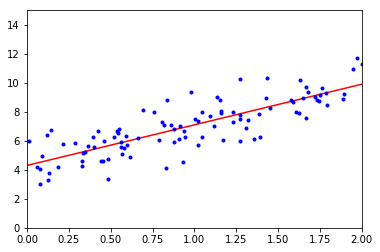

In [13]:
plt.plot(x_new, y_pred, "r-")
plt.plot(x, y, "b.")
plt.axis([0,2,0,15])
plt.show()

In [14]:
# Equivalent using sklearn

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x, y)
y_pred = lin_reg.predict(x_new)
y_pred

array([[4.29952091],
       [9.90526384]])


Computation complexitiy approx 
  * `O(n**3)` (n = number of features) (very slow if features > 100k)
  * `O(m)` (m = number of instances)
Requires all training data to fit in memory

After training, predictions are very fast

## Gradient Descent

Measures local gradient of error function with regards to paramater vector theta and traverses in direction of steepest downward gradient

Important paramaters:
* random initialization (may influence whether algorithm gets stuck in a local minimum
* learning rate (size of steps along gradient)

Score function for linear regression is always convex (so no local minimum). Guarnteed to always reach arbitraily close to global minimum, given an appropriate learning rate. This can take a long time if all features aren't appropriately scaled beforehand.

### Batch Gradient Descent

Uses entire training set (i.e. in a batch) during each step
Calculates the gradient vector made up of the partial derivates of the cost function in terms of each paramater in theta.

In [17]:
# Calculate the gradient vector

eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) #random initialization

for iteration in range(n_iterations):
    gradients = 2 / m * x_b.T @ ( x_b @ theta - y)
    theta = theta - eta * gradients
theta

array([[4.29952091],
       [2.80287147]])

### Stochastic Gradient Descent

Batch GD very slow when training set is very large

Stochastic GD works on only one instance from the training set at a time, chosen at random.

Less sensitive to local minimia since it jumps around randomly

Does not stop when global minimum reached. Use `simulated annealing` with a `learning schedule` to reduce learning rate as global minimum is approached


In [19]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyper-params

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = x_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T @ ( xi @ theta - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

theta

array([[4.28177809],
       [2.77623281]])

In [21]:
# Using sklearn

from sklearn.linear_model import SGDRegressor

# Uses 50 epochs, no regularization (penalty) and learning rate of 0.1 (w/ default learning schedule)
sgd_reg = SGDRegressor(n_iter = 50, penalty=None, eta0=0.1)
sgd_reg.fit(x, y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)

[4.33250548] [2.85798563]


### Mini-batch gradient descent

Intermediate technique between batch and pure stochastic GD

Each step calculates gradients using a random sample of training set instances. This gives a speed boost derived from GPU acceleration of matrix operations.

Algorithm |Large m | Out-of-core support | Large n | Hyperparams | Scaling required | Scikit-Learn
- | - | - | - | - | 
Normal Equation | Fast | No | Slow | 0 | No | LinearRegression 
Batch GD | Slow | No | Fast | 2 | Yes | n/a | 
Stochastic GD | Fast | Yes | Fast | ≥2 | Yes | SGDRegressor | 
Mini-batch GD | Fast | Yes | Fast | ≥2 | Yes | SGDRegressor |

## Polynomial Regression

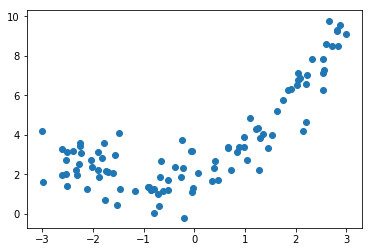

In [23]:
m = 100
x = 6 * np.random.rand(m, 1 ) - 3
y = 0.5 * x ** 2 + x + 2 + np.random.randn(m, 1)

plt.scatter(x,y)
plt.show()

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
x_poly = poly_features.fit_transform(x)

Features now include original data and square of data. Can fit linear model to the later feature

In [26]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[1.99853019] [[0.96818302 0.50951219]]


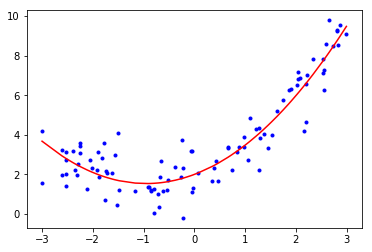

In [80]:

x_sort = np.sort(x,0)
x_poly_sort = poly_features.fit_transform(x_sort)
y_pred = lin_reg.predict(x_poly_sort)

plt.plot(x, y, 'b.')
plt.plot(x_sort, y_pred, 'r-')
plt.show()

### Learning Curves

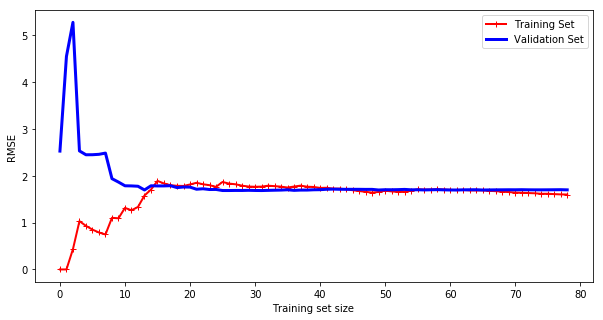

In [102]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y, ymax = None):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.figure(figsize = (10, 5))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="Training Set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation Set")
    plt.legend()
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    if ymax:
        plt.ylim((0, ymax))
    
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x, y)

Characteristic of an underfititng model (both curves plateau rather high).

Try to overfit using 10th degree polynomial

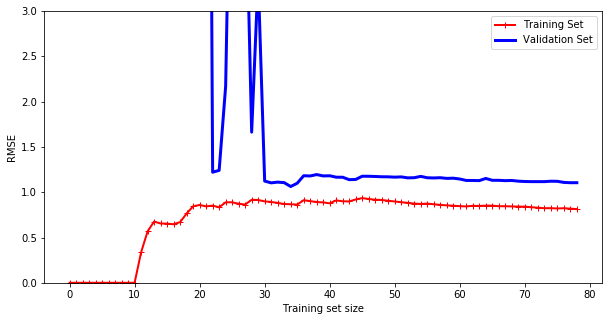

In [111]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, x, y, ymax = 3)

Indicators of overfitting: 

* Error on training set lower than w/ linear model
* Errors never converge (validation set plateaus higher

Bias/Variance tradeoff

* Bias : Error due to wrong assumptions about relationship between variables, or data distribution
* Variance : Error due to extreme sensitivity to variatin in training set
* Irreducible error : Error due to noisiness in training data

More complex models decrease bias but increase variance, typically

### Regularized Linear Models

To reduce overfitting, regularize (constrain) the model.

For polynomial models, reduce degrees of freedom
For linear models, constrain model weights

#### Ridge regression (Tikhonov regression)

A regularization term equal to the sum of the squares of the model coefficients is added to the cost equation. Forces model to minimize weights.

Use only during training, not validation or in production

Ridge regression cost function: 


\begin{align}
\large
J(\theta) = MSE(\theta) + \alpha\frac{1}{2}\sum_{i=1}^{n} \theta_{i}^2
\end{align}




In [114]:
# Using a closed-form solution

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(x, y)
ridge_reg.predict([[1.5]])

array([[8.26067403]])

In [120]:
# Using SGD

sgd_reg = SGDRegressor(penalty = "l2")
sgd_reg.fit(x, y.ravel())
sgd_reg.predict([[1.5]])

/Users/mike/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([8.15912247])

#### Lasso Regression 

Least Absolute Shrinkate and Selection Operator (LASSO) Regression

Similar to ridge regression but uses the $\ell_1$ norm of the weight vector instead of $\frac{1}{2}{\ell_2}^2$

Cost function:

$$
\large
J(\theta) = MSE(\theta) + \alpha\sum_{i=1}^{n} |\theta_i|
$$

Tends to eliminate weights of least important factors


In [121]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(x, y)
lasso_reg.predict([[1.5]])

array([8.17616471])

In [122]:
# Using SGD

sgd_reg = SGDRegressor(penalty = "l1")
sgd_reg.fit(x, y.ravel())
sgd_reg.predict([[1.5]])

/Users/mike/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([8.16890328])

#### Elastic net

Simple mixture of ridge and lasso regression, using a mix ration *r*.
*r* = 0 -> eq to ridge regression
*r* = 1 -> eq to lasso regression

$$
\large
J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^{n}|\theta_{i}| + \frac{1 - r}{2}\alpha\sum_{i=1}^{n} \theta_i^2
$$

Should generally always use some regulariation when dealing with linear regression.

Implemented in `sklearn.linear_model.ElasticNet`. l1_ratio argument corresponds to *r*

Ridge is a good default
Lasso if you suspect only some features are useful
Elastic net generally prefered over lasso as it handles correlated features and large numbers of features cmpared to size of training set better

### Early stopping

Stop training as soon as RMSE reaches a minimum

In [147]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.2, random_state = 2251)
x_train_poly_scaled = poly_scaler.fit_transform(x_train)
x_val_poly_scaled= poly_scaler.transform(x_val)

sgd_reg = SGDRegressor(max_iter = 1, warm_start = True, penalty = None,
                      learning_rate="constant", eta0=0.0005, random_state=589)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(x_train_poly_scaled, y_train.ravel())
    y_val_predict = sgd_reg.predict(x_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
print(best_epoch)

71


### Logistic (Logit) Regression

Binary classification using linear regression.

Calculates weighted sum of input featues, as in linear regression. But instead of outputting the result directly, it outputs the logistic of this result.

$$
\large
\hat{p} = h_\theta(\textbf{x}) = \sigma(\theta^{T}\cdot\textbf{x})
$$

Logistic, denoted $\sigma(\cdot)$, is a sigmoidal function (S-shaped) between (0,1).

$$
\large
\sigma(t) = \frac{1}{1 + e^{-t}}
$$

Predicts y to be 1 or 0 if $\hat{p}$ >= 0.5 or < 0.5, respectively

$$
\large
c(\theta)=\left\{
\begin{array}{c l}	
     -log(\hat{p}) &\text{ if } y = 1,\\
     -log(1 - \hat{p}) &\text{ if } y = 0.
\end{array}\right.
$$

Cost becomes high if gives probabilites near zero, and zero as probabilities become near 1 and -1 for positive and negative instances

Cost function is the average cost over all training instances

$$
J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(\hat{p}^{(i)}) + (1 -y^{(i)})log(1 - \hat{p}^{(i)})]
$$

There's no closed solution, but derivatie is convex so can always be solved by gradient descent.

### Decision boundaries

Analyze the iris dataset using a logistic classifier

In [150]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [158]:
x = iris["data"][:,3:] #petal width
y = (iris["target"] == 2).astype(np.int) # 1 if iris-virginica, else 0

In [160]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

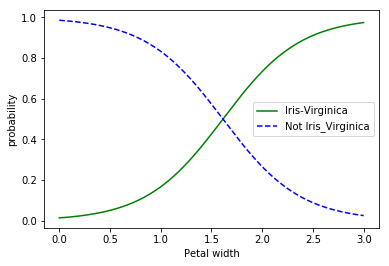

In [165]:
x_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(x_new)
plt.plot(x_new, y_proba[:,1], "g-", label = "Iris-Virginica")
plt.plot(x_new, y_proba[:,0], "b--", label = "Not Iris_Virginica")
plt.legend()
plt.xlabel("Petal width") 
plt.ylabel("probability")
plt.show()

### Softmax Regression

Logistic regressors can be trained to be multiclassifiers using softmax or multinomial logistic regression 